# Count time-based keyword frequency

To draw daily line chart on a web page, we need to count date-based frequency.

    The data format for the line chart is as follows.

    [{'x': '2020-03-05', 'y': 1},
    {'x': '2020-03-06', 'y': 0},
    {'x': '2020-03-07', 'y': 0},
    {'x': '2020-03-08', 'y': 0},
    {'x': '2020-03-09', 'y': 0},
    {'x': '2020-03-10', 'y': 5},
    {'x': '2020-03-11', 'y': 5},
    {'x': '2020-03-12', 'y': 7},
    {'x': '2020-03-13', 'y': 62},
    {'x': '2020-03-14', 'y': 29}]

# Load data

In [1]:
import pandas as pd
from datetime import datetime,timedelta

In [2]:
df = pd.read_csv('./cna_news_preprocessed.csv',sep='|')

In [3]:
df.head(1)

,item_id,date,category,title,content,sentiment,summary,top_key_freq,tokens,tokens_v2,entities,token_pos,link,photo_link
0,aipl_20220314_1,2022-03-14,政治,外交部援烏物資已募4000箱 吳釗燮感謝捐贈民眾,民眾捐贈烏克蘭的愛心物資持續湧入外交部，截至今天傍晚累計已收到約4000箱，外交部長吳釗燮中...,0.01,"['外交部除感謝熱心民眾踴躍捐贈援助烏克蘭人道物資外', '親赴外交部捐贈物資的民眾約173...","[('外交部', 14), ('民眾', 7), ('物資', 7), ('烏克蘭', 5)...","['民眾', '捐贈', '烏克蘭', '的', '愛心', '物資', '持續', '湧入...","['民眾', '烏克蘭', '愛心', '物資', '外交部', '收到', '外交部長',...","[NerToken(word='烏克蘭', ner='GPE', idx=(4, 7)), ...","[('民眾', 'Na'), ('捐贈', 'VD'), ('烏克蘭', 'Nc'), ('...",https://www.cna.com.tw/news/aipl/202203140364....,https://imgcdn.cna.com.tw/www/WebPhotos/200/20...


# Filter data using token_v2 or content column

In [4]:
from datetime import datetime, timedelta
# Searching keywords from "content" column
# Here this function uses df.content column, while filter_dataFrame() uses df.tokens_v2
def filter_dataFrame(user_keywords, cond, cate, weeks):

    # end date: the date of the latest record of news
    end_date = df.date.max()
    
    # start date
    start_date = (datetime.strptime(end_date, '%Y-%m-%d').date() - timedelta(weeks=weeks)).strftime('%Y-%m-%d')

    # (1) proceed filtering: a duration of a period of time
    # 期間條件
    period_condition = (df.date >= start_date) & (df.date <= end_date) 
    
    # (2) proceed filtering: news category
    # 新聞類別條件
    if (cate == "全部"):
        condition = period_condition  # "全部"類別不必過濾新聞種類
    else:
        # category新聞類別條件
        condition = period_condition & (df.category == cate)

    # (3) proceed filtering: keywords 
    # and or 條件
    if (cond == 'and'):
        # query keywords condition使用者輸入關鍵字條件and
        condition = condition & df.content.apply(lambda text: all((qk in text) for qk in user_keywords)) #寫法:all()
    elif (cond == 'or'):
        # query keywords condition使用者輸入關鍵字條件
        condition = condition & df.content.apply(lambda text: any((qk in text) for qk in user_keywords)) #寫法:any()
    # condiction is a list of True or False boolean value
    df_query = df[condition]

    return df_query


### Now we do filtering news

In [5]:
# user_keywords=['肺炎','冠狀','疫情']
# cond='and'
# cate='全部'
# weeks=4
# df_query = filter_dataFrame(user_keywords, cond, cate, weeks)

In [6]:
user_keywords=['烏克蘭','俄羅斯']
cond='or'
cate='全部'
weeks=4
df_query = filter_dataFrame(user_keywords, cond, cate, weeks)
len(df_query)

26

In [7]:
df_query.head(1)

,item_id,date,category,title,content,sentiment,summary,top_key_freq,tokens,tokens_v2,entities,token_pos,link,photo_link
0,aipl_20220314_1,2022-03-14,政治,外交部援烏物資已募4000箱 吳釗燮感謝捐贈民眾,民眾捐贈烏克蘭的愛心物資持續湧入外交部，截至今天傍晚累計已收到約4000箱，外交部長吳釗燮中...,0.01,"['外交部除感謝熱心民眾踴躍捐贈援助烏克蘭人道物資外', '親赴外交部捐贈物資的民眾約173...","[('外交部', 14), ('民眾', 7), ('物資', 7), ('烏克蘭', 5)...","['民眾', '捐贈', '烏克蘭', '的', '愛心', '物資', '持續', '湧入...","['民眾', '烏克蘭', '愛心', '物資', '外交部', '收到', '外交部長',...","[NerToken(word='烏克蘭', ner='GPE', idx=(4, 7)), ...","[('民眾', 'Na'), ('捐贈', 'VD'), ('烏克蘭', 'Nc'), ('...",https://www.cna.com.tw/news/aipl/202203140364....,https://imgcdn.cna.com.tw/www/WebPhotos/200/20...


# All-in-one function: Get time-based keyword frequency

In [35]:
def get_keyword_time_based_freq(df_query):
    date_samples = df_query.date
    query_freq = pd.DataFrame({'date_index':pd.to_datetime( date_samples ),'freq':[1 for _ in range(len(df_query))]})
    data = query_freq.groupby(pd.Grouper(key='date_index',freq='D')).sum()
    time_data=[]
    for i, date_idx in enumerate(data.index):
        row = {'x':date_idx.strftime('%Y-%m-%d'),'y':int(data.iloc[i].freq)}
        time_data.append(row)
    return time_data

In [36]:
user_keywords=['烏克蘭','俄羅斯']
cond='or'
cate='全部'
weeks=4
df_query = filter_dataFrame(user_keywords, cond, cate, weeks)
len(df_query)

26

In [10]:
result = get_keyword_time_based_freq(df_query)

In [37]:
result

[{'x': '2022-03-09', 'y': 1},
 {'x': '2022-03-10', 'y': 0},
 {'x': '2022-03-11', 'y': 1},
 {'x': '2022-03-12', 'y': 0},
 {'x': '2022-03-13', 'y': 2},
 {'x': '2022-03-14', 'y': 22}]

In [38]:
len(result)

6

# Demonstration step by step

# Time-based frequency

    We need the daily frequency data:

    [{'x': '2020-02-24', 'y': 1},
    {'x': '2020-02-25', 'y': 0},
    {'x': '2020-02-26', 'y': 1},
    {'x': '2020-02-27', 'y': 1},
    {'x': '2020-02-28', 'y': 0},
    {'x': '2020-02-29', 'y': 0},
    {'x': '2020-03-01', 'y': 0},
    {'x': '2020-03-02', 'y': 2},
    {'x': '2020-03-03', 'y': 1}]

## Assign frequency value of 1 to each news

        date_index  freq
    0	2020-03-20	1
    1	2020-03-20	1
    2	2020-03-13	1
    3	2020-03-19	1
    4	2020-03-17	1

In [39]:
# done with one line:
query_freq = pd.DataFrame({'date_index':pd.to_datetime( df_query.date ),'freq':[1 for _ in range(len(df_query))]})

In [40]:
query_freq

,date_index,freq
0,2022-03-14,1
11,2022-03-14,1
19,2022-03-14,1
22,2022-03-11,1
33,2022-03-09,1
56,2022-03-13,1
61,2022-03-14,1
75,2022-03-14,1
84,2022-03-14,1
88,2022-03-14,1


### How to make it?

In [15]:
{'key':['one','two','three'], 'value':[1,2,3]}

{'key': ['one', 'two', 'three'], 'value': [1, 2, 3]}

In [16]:
pd.DataFrame({'key':['one','two','three'], 'value':[1,2,3]})

,key,value
0,one,1
1,two,2
2,three,3


In [17]:
{'date_index':pd.to_datetime( df_query.date ),'freq':[1 for _ in range(len(df_query))]}

{'date_index': 0     2022-03-14
 11    2022-03-14
 19    2022-03-14
 22    2022-03-11
 33    2022-03-09
 56    2022-03-13
 61    2022-03-14
 75    2022-03-14
 84    2022-03-14
 88    2022-03-14
 98    2022-03-14
 107   2022-03-14
 110   2022-03-14
 140   2022-03-14
 141   2022-03-14
 142   2022-03-14
 143   2022-03-14
 144   2022-03-14
 149   2022-03-14
 151   2022-03-14
 152   2022-03-14
 179   2022-03-14
 184   2022-03-14
 191   2022-03-13
 195   2022-03-14
 204   2022-03-14
 Name: date, dtype: datetime64[ns],
 'freq': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [18]:
df_query.date # date is string format

0      2022-03-14
11     2022-03-14
19     2022-03-14
22     2022-03-11
33     2022-03-09
56     2022-03-13
61     2022-03-14
75     2022-03-14
84     2022-03-14
88     2022-03-14
98     2022-03-14
107    2022-03-14
110    2022-03-14
140    2022-03-14
141    2022-03-14
142    2022-03-14
143    2022-03-14
144    2022-03-14
149    2022-03-14
151    2022-03-14
152    2022-03-14
179    2022-03-14
184    2022-03-14
191    2022-03-13
195    2022-03-14
204    2022-03-14
Name: date, dtype: object

In [19]:
# convert to datetime format
pd.to_datetime( df_query.date )

0     2022-03-14
11    2022-03-14
19    2022-03-14
22    2022-03-11
33    2022-03-09
56    2022-03-13
61    2022-03-14
75    2022-03-14
84    2022-03-14
88    2022-03-14
98    2022-03-14
107   2022-03-14
110   2022-03-14
140   2022-03-14
141   2022-03-14
142   2022-03-14
143   2022-03-14
144   2022-03-14
149   2022-03-14
151   2022-03-14
152   2022-03-14
179   2022-03-14
184   2022-03-14
191   2022-03-13
195   2022-03-14
204   2022-03-14
Name: date, dtype: datetime64[ns]

In [20]:
[1 for _ in range(len(df_query))]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [21]:
# dict format 
{'date_index':pd.to_datetime( df_query.date ),'freq':[1 for _ in range(len(df_query))]}

{'date_index': 0     2022-03-14
 11    2022-03-14
 19    2022-03-14
 22    2022-03-11
 33    2022-03-09
 56    2022-03-13
 61    2022-03-14
 75    2022-03-14
 84    2022-03-14
 88    2022-03-14
 98    2022-03-14
 107   2022-03-14
 110   2022-03-14
 140   2022-03-14
 141   2022-03-14
 142   2022-03-14
 143   2022-03-14
 144   2022-03-14
 149   2022-03-14
 151   2022-03-14
 152   2022-03-14
 179   2022-03-14
 184   2022-03-14
 191   2022-03-13
 195   2022-03-14
 204   2022-03-14
 Name: date, dtype: datetime64[ns],
 'freq': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [22]:
# conver to dataframe
pd.DataFrame({'date_index':pd.to_datetime( df_query.date ),'freq':[1 for _ in range(len(df_query))]})

,date_index,freq
0,2022-03-14,1
11,2022-03-14,1
19,2022-03-14,1
22,2022-03-11,1
33,2022-03-09,1
56,2022-03-13,1
61,2022-03-14,1
75,2022-03-14,1
84,2022-03-14,1
88,2022-03-14,1


In [23]:
query_freq = pd.DataFrame({'date_index':pd.to_datetime( df_query.date ),'freq':[1 for _ in range(len(df_query))]})

## Daily frequency

### We use pd.Grouper(). It is very powerful.

In [24]:
query_freq.groupby(pd.Grouper(key='date_index',freq='D')).sum()

,freq
date_index,
2022-03-09,1
2022-03-10,0
2022-03-11,1
2022-03-12,0
2022-03-13,2
2022-03-14,22


In [25]:
pd.Grouper(key='date_index',freq='D')

TimeGrouper(key='date_index', freq=<Day>, axis=0, sort=True, dropna=True, closed='left', label='left', how='mean', convention='e', origin='start_day')

In [42]:
query_freq.groupby(pd.Grouper(key='date_index',freq='W')).sum()

,freq
date_index,
2022-03-13,4
2022-03-20,22


## Week-based frequency

In [26]:
query_freq.groupby(pd.Grouper(key='date_index',freq='W')).sum()

,freq
date_index,
2022-03-13,4
2022-03-20,22


## draw freqency line chart

In [27]:
# data = query_freq.groupby(pd.Grouper(key='date_index',freq='D')).sum()[['freq']]
data = query_freq.groupby(pd.Grouper(key='date_index',freq='D')).sum()[['freq']]

In [28]:
data

,freq
date_index,
2022-03-09,1
2022-03-10,0
2022-03-11,1
2022-03-12,0
2022-03-13,2
2022-03-14,22


In [29]:
type(data)

pandas.core.frame.DataFrame

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

<Axes: xlabel='date_index'>

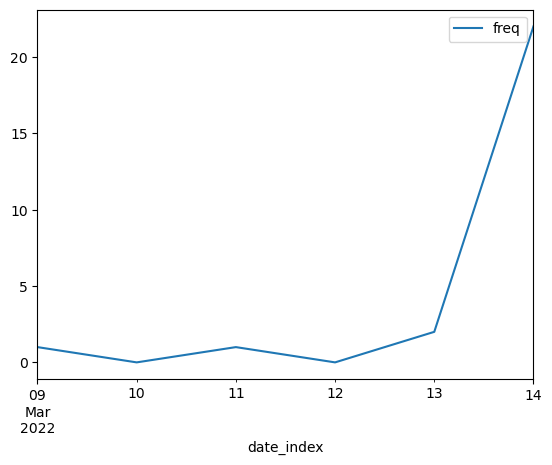

In [31]:
data.plot()

## Prepare data format for JavaScrip line chart on Django website

In [32]:
data.head(2)

,freq
date_index,
2022-03-09,1
2022-03-10,0


In [33]:
time_data=[]
for i, date_idx in enumerate(data.index):
    row = {'x':date_idx.strftime('%Y-%m-%d'),'y':int(data.iloc[i].freq)}
    time_data.append(row)

In [34]:
time_data

[{'x': '2022-03-09', 'y': 1},
 {'x': '2022-03-10', 'y': 0},
 {'x': '2022-03-11', 'y': 1},
 {'x': '2022-03-12', 'y': 0},
 {'x': '2022-03-13', 'y': 2},
 {'x': '2022-03-14', 'y': 22}]

# All-in-one function: Get time-based keyword frequency

# views.py for app_user_keyword